In [ ]:
!pip install richdem
!pip install elevation
!pip install geopandas
!pip install rasterio
!pip install pycrs

     |████████████████████████████████| 4.5MB 2.8MB/s 
     |████████████████████████████████| 71kB 3.3MB/s 
ERROR: pip-tools 4.5.1 has requirement click>=7, but you'll have click 6.7 which is incompatible.
  Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
     |████████████████████████████████| 931kB 2.8MB/s 
     |████████████████████████████████| 14.7MB 282kB/s 
     |████████████████████████████████| 10.9MB 46.4MB/s 
     |████████████████████████████████| 18.2MB 255kB/s 
  Created wheel for pycrs: filename=PyCRS-1.0.2-cp36-none-any.whl size=32683 sha256=9b4d1e67985347502b7b01bb12a8e769ec3a7b88745fad36e9850def7a2db53b
  Stored in directory: /root/.cache/pip/wheels/1a/c9/56/648f762bd41fdb03454be51b8a7069795925168833cb61f316
Successfully built pycrs


In [ ]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
import elevation
import richdem as rd
import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.mask import mask
from shapely.geometry import box
from fiona.crs import from_epsg
import pycrs

matplotlib.rcParams['figure.figsize'] = (8, 5.5)

In [ ]:
dem_path = os.path.join(os.getcwd(), 'istanbul-30m-DEM.tif')
elevation.clip(bounds=(27.9, 40.7, 29.9, 41.7), output=dem_path)

In [ ]:
istanbul_dem = rd.LoadGDAL(dem_path)

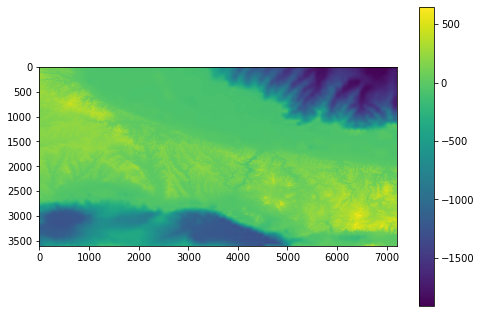

In [ ]:
plt.imshow(istanbul_dem, interpolation='none')
plt.colorbar()
plt.show()

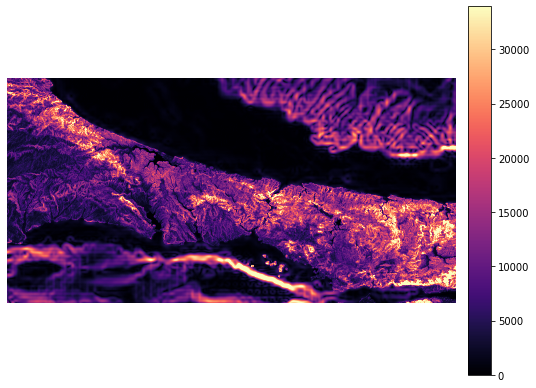

In [ ]:
slope = rd.TerrainAttribute(istanbul_dem, attrib='slope_riserun')
rd.rdShow(slope, axes=False, cmap='magma', figsize=(8, 5.5))
plt.show()

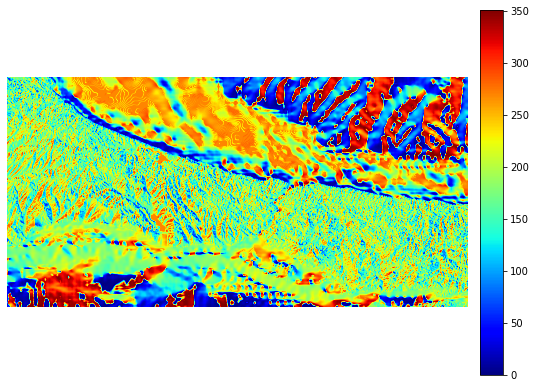

In [ ]:
aspect = rd.TerrainAttribute(istanbul_dem, attrib='aspect')
rd.rdShow(aspect, axes=False, cmap='jet', figsize=(8, 5.5))
plt.show()

In [ ]:
rd.SaveGDAL('./slope.tif', slope)

In [ ]:
fp = r"./slope.tif"
out_tif = r"./istanbul_slope.tif"

In [ ]:
!wget 'https://cografiveri.s3.amazonaws.com/istanbul.geojson'

--2020-05-17 20:13:56--  https://cografiveri.s3.amazonaws.com/istanbul.geojson
Resolving cografiveri.s3.amazonaws.com (cografiveri.s3.amazonaws.com)... 52.217.64.188
Connecting to cografiveri.s3.amazonaws.com (cografiveri.s3.amazonaws.com)|52.217.64.188|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8347945 (8.0M) [binary/octet-stream]
Saving to: ‘istanbul.geojson’

istanbul.geojson    100%[===================>]   7.96M  --.-KB/s    in 0.1s    

2020-05-17 20:13:56 (66.6 MB/s) - ‘istanbul.geojson’ saved [8347945/8347945]



In [ ]:
data = rasterio.open(fp)

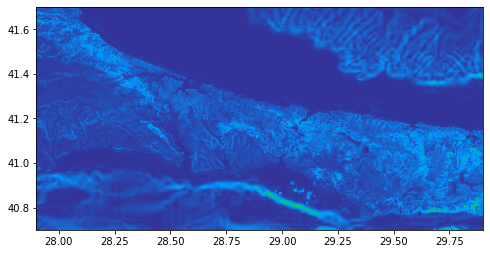

In [ ]:
show((data, 1), cmap='terrain')

In [ ]:
# Open crop extent (your study area extent boundary)
istanbul_bound = gpd.read_file("./istanbul.geojson")

In [ ]:
epsg_code = int(data.crs.data['init'][5:])
print(epsg_code)

4326


In [ ]:
print(istanbul_bound.crs)

epsg:4326


In [ ]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [ ]:
coords = getFeatures(istanbul_bound)
#print(coords)

In [ ]:
out_img, out_transform = mask(dataset=data, shapes=coords, crop=True)

In [ ]:
out_meta = data.meta.copy()
print(out_meta)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 7200, 'height': 3600, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0002777777777777778, 0.0, 27.89986111111111,
       0.0, -0.0002777777777777778, 41.700138888888894)}


In [ ]:
epsg_code = int(data.crs.data['init'][5:])
print(epsg_code)

4326


In [ ]:
out_meta.update({"driver": "GTiff",
                  "height": out_img.shape[1],
                  "width": out_img.shape[2],
                  "transform": out_transform,
                  "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()})

In [ ]:
with rasterio.open(out_tif, "w", **out_meta) as dest:
     dest.write(out_img)

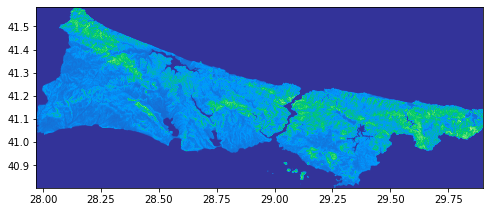

In [ ]:
clipped = rasterio.open(out_tif)

show((clipped, 1), cmap='terrain')